## TITTLE: SALES FORECASTING WITH LSTM AND SARIMA MODEL

Topic/ Expected Result: Prediksi penjualan dalam kurun waktu 6 bulan kedepan secara time series

Objectives:
1. Melakukan eksplorasi penjualan super store dari waktu ke waktu

2. Membuat prediksi penjualan untuk 12 bulan ke depan

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.9 MB/s eta 0:00:00


In [3]:
#import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import matplotlib.ticker as ticker
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [4]:
import pandas as pd
pd.set_option("display.max_columns",None)


df = pd.read_csv('/content/drive/MyDrive/DIBIMBING.ID/FINAL PROJECT CEMUNGUT/DS 23B_Novia Khusna Faizah - Progress Script Final Project.ipynb/Superstore.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


## DATA PREPROCESSING

In [5]:
# Menampilkan informasi umum tentang Data Frame

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [6]:
# Memeriksa baris yang berisi nilai kosong

df.isnull().any()

Row ID           False
Order ID         False
Order Date       False
Ship Date        False
Ship Mode        False
Customer ID      False
Customer Name    False
Segment          False
Country          False
City             False
State            False
Postal Code       True
Region           False
Product ID       False
Category         False
Sub-Category     False
Product Name     False
Sales            False
dtype: bool

In [7]:
# Memeriksa baris yang berisi nilai kosong Postal Code

df[df['Postal Code'].isnull()]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
2234,2235,CA-2018-104066,05/12/2018,10/12/2018,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5274,5275,CA-2016-162887,07/11/2016,09/11/2016,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8798,8799,US-2017-150140,06/04/2017,10/04/2017,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9146,9147,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9147,9148,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
9148,9149,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9386,9387,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92
9387,9388,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28
9388,9389,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94
9389,9390,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-EN-10001509,Office Supplies,Envelopes,Poly String Tie Envelopes,2.04


In [8]:
# Terdapat 1 jenis city dan state yang berisi nilai kosong, maka dapat disesuaikan dengan postal codenya

df['Postal Code'] = df['Postal Code'].fillna(5401)


In [9]:
# Melakukan pendeteksian ulang data yang kosong (missing values)

df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64

In [10]:
# Mendeteksi data duplikat

df.duplicated().any()

False

In [11]:
# Memeriksa sebaran data numerik

df.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9800.000000,9800.000000
mean,4900.500000,55217.343265,230.769059
std,2829.160653,32066.750532,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,57551.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


In [12]:
# Menghapus Row ID dan Postal Code (Karena dianggap tidak memberikan informasi yang berguna atau signifikan)

df2 = df.drop(['Row ID','Postal Code'], axis=1)

df2.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [13]:
# Merubah format order date dan ship date dari object ke time series

df2['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

df2['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')

In [14]:
# Mengurutkan data date time

df2.sort_values(by=['Order Date'], inplace=True, ascending=True)

In [95]:

# 1. Uji Stasioneritas Data dengan Augmented Dickey-Fuller Test

from statsmodels.tsa.stattools import adfuller

result = adfuller(df2['Sales'])

# Tampilkan hasil uji
print('ADF Statistic:', result[0])
print('P-value:', result[1])
print('Critical Values:', result[4])

# Interpretasi hasil
if result[1] > 0.05:
    print('Time series is not stationary.')
else:
    print('Time series is stationary.')

ADF Statistic: -99.08279579913294
P-value: 0.0
Critical Values: {'1%': -3.4310175185079284, '5%': -2.861835002806603, '10%': -2.566927024865997}
Time series is stationary.


Time series is stationary.


In [94]:
# 2. Uji Stasioneritas Data dengan KPSS

result2 = kpss(df2['Sales'])

print('KPSS Statistic:', result2[0])
print('P-value:', result2[1])
print('Critical Values:', result2[3])

# Interpretasi hasil
if result2[1] > 0.05:
    print('Time series is stationary.')
else:
    print('Time series is not stationary.')

KPSS Statistic: 0.1118274706161094
P-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Time series is stationary.


<ipython-input-94-8fec7e699e80>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result2 = kpss(df2['Sales'])


In [19]:
# Aggregate all daily revenue
time_sales = df2.groupby("Order Date").sum()
time_sales

<ipython-input-19-b82b803056be>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_sales = df2.groupby("Order Date").sum()


,Sales
Order Date,
2015-01-03,16.4480
2015-01-04,288.0600
2015-01-05,19.5360
2015-01-06,4407.1000
2015-01-07,87.1580
...,...
2018-12-26,814.5940
2018-12-27,177.6360
2018-12-28,1657.3508


In [20]:
# reset the index for graphing purpose
time_sales1 = time_sales.copy()
time_sales1.reset_index(inplace=True)

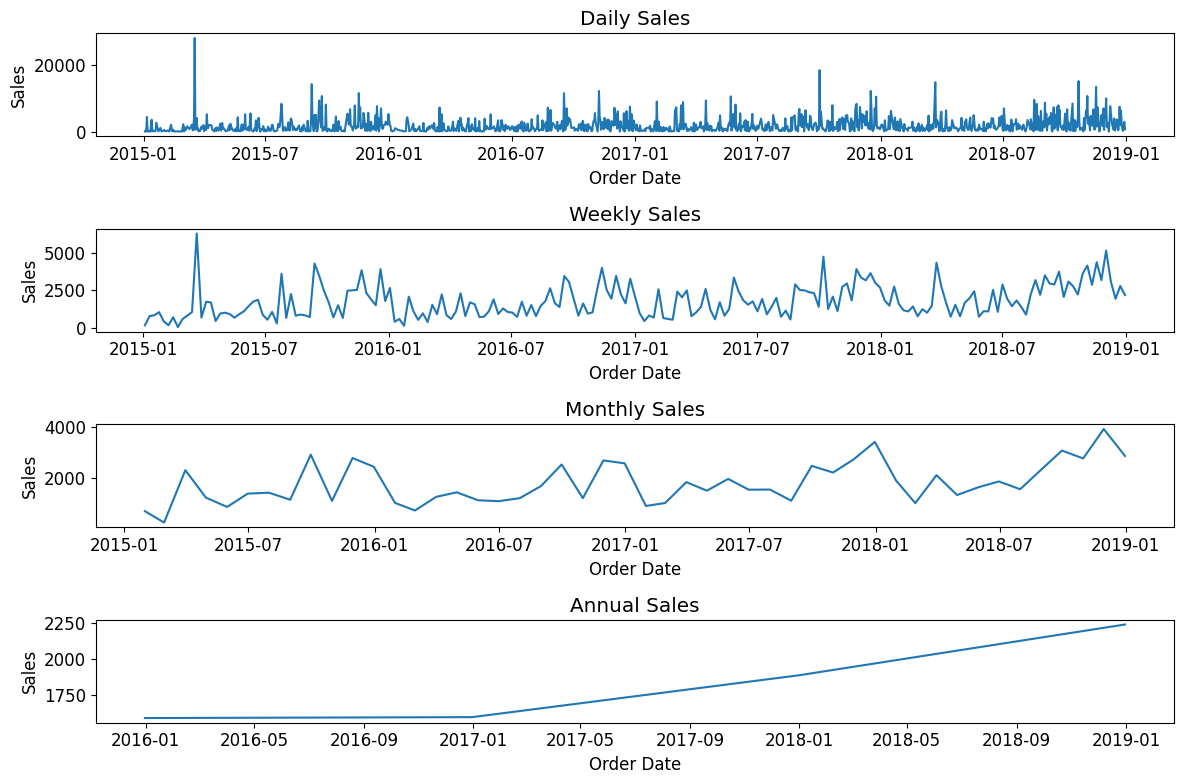

In [82]:
# Resample the data on 'Sales' price weekly
sale_weekly = time_sales1.resample('W', on='Order Date').mean()

# Resample the data on 'Sales' price monthly
sale_monthly = time_sales1.resample('M', on='Order Date').mean()

# Resample the data on 'Sales' price monthly
sale_annualy = time_sales1.resample('A', on='Order Date').mean()

# Visualization
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,8))

sns.lineplot(x='Order Date', y='Sales', data=time_sales1, ax=ax1)
ax1.set_title('Daily Sales')

sns.lineplot(x='Order Date', y='Sales', data=sale_weekly, ax=ax2)
ax2.set_title('Weekly Sales')

sns.lineplot(x='Order Date', y='Sales', data=sale_monthly, ax=ax3)
ax3.set_title('Monthly Sales')

sns.lineplot(x='Order Date', y='Sales', data=sale_annualy, ax=ax4)
ax4.set_title('Annual Sales')

plt.tight_layout()

In [22]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(sale_monthly, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

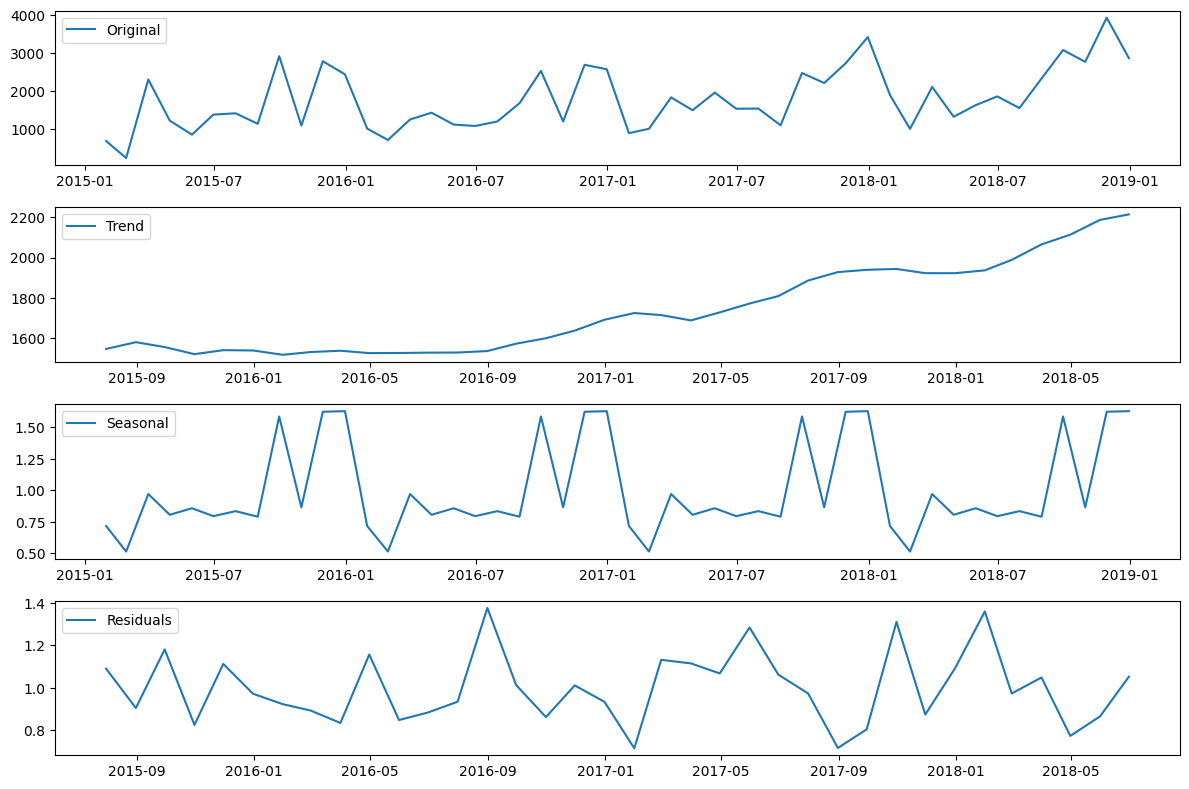

In [23]:
# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(sale_monthly, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

## EXPLORATORY DATA ANALYSIS


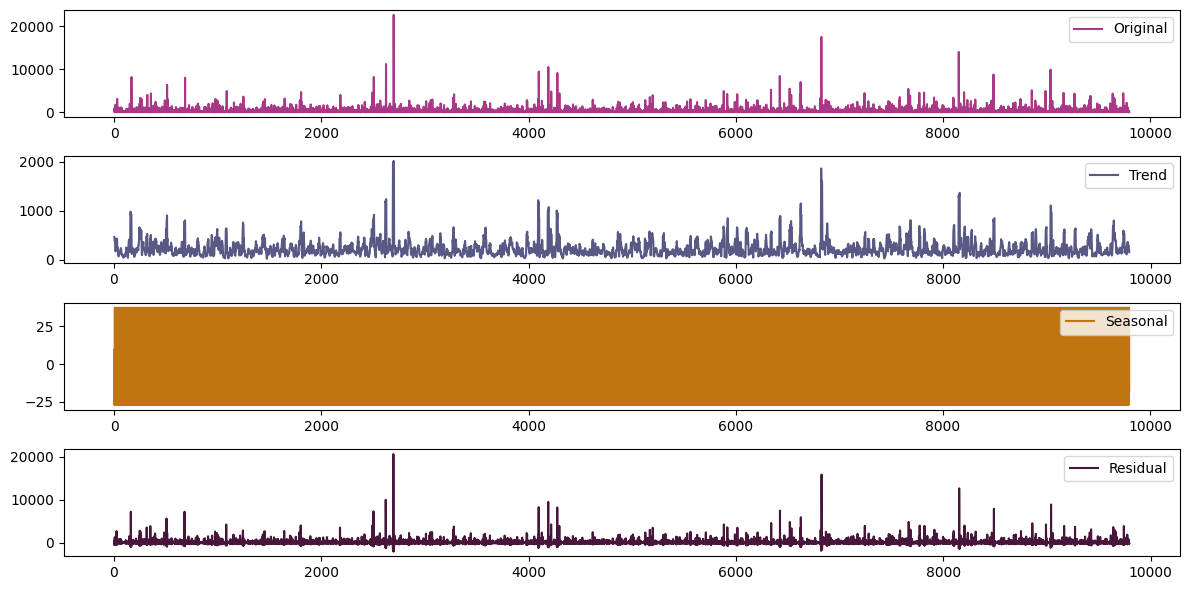

In [24]:
# Melakukan dekomposisi deret waktu untuk melihat Sales Trend

decomposition = seasonal_decompose(df['Sales'], period=12)

# Plotting the original time series
plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(df['Sales'], color='#a93886', label='Original')
plt.legend()


# Plotting the trend component
plt.subplot(412)
plt.plot(decomposition.trend, color='#595985', label='Trend')
plt.legend()

# Plotting the seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal, color='#c17511', label='Seasonal')
plt.legend()

# Plotting the residual component
plt.subplot(414)
plt.plot(decomposition.resid, color='#47163a', label='Residual')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [25]:
# Negara yang memiliki kontribusi paling tinggi

Top_states = df.groupby(["State"]).sum().sort_values("Sales", ascending=False).head(20) # Sort the States as per the sales
Top_states = Top_states[["Sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_states.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the states into dataframe

<ipython-input-25-a09faba86132>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Top_states = df.groupby(["State"]).sum().sort_values("Sales", ascending=False).head(20) # Sort the States as per the sales


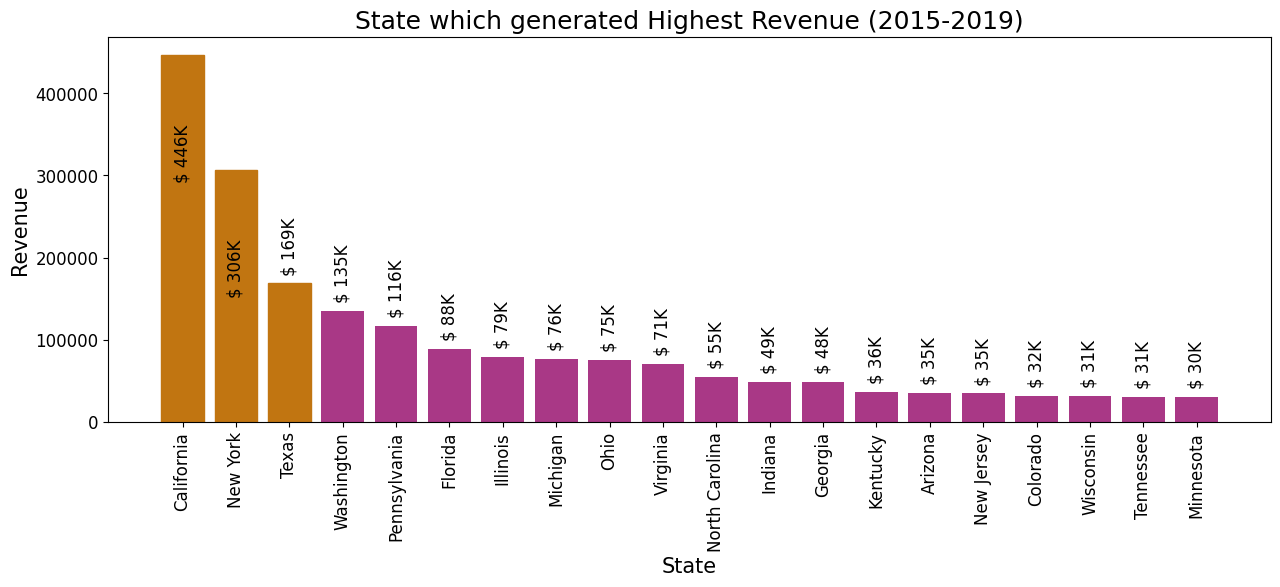

In [26]:
# Define colors for the top 3 bars
colors = ['#c17511', '#c17511', '#c17511']

plt.figure(figsize=(15, 5))
plt.title("State which generated Highest Revenue (2015-2019)", fontsize=18)

# Plot bars with different colors for the top 3
bars = plt.bar(Top_states["State"], Top_states["Sales"], color=['#a93886'] * len(Top_states))

# Assign different colors to the top 3 bars
for i in range(3):
    bars[i].set_color(colors[i])

plt.xlabel("State", fontsize=15)
plt.ylabel("Revenue", fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

# Add annotations with revenue in K (thousands)
for k, v in Top_states["Sales"].items():
    revenue_in_k = v / 1000  # Convert revenue to thousands
    if revenue_in_k > 250:
        plt.text(k, v - 150000, f'$ {revenue_in_k:.0f}K', fontsize=12, rotation=90, color='k', horizontalalignment='center')
    else:
        plt.text(k, v + 15000, f'$ {revenue_in_k:.0f}K', fontsize=12, rotation=90, color='k', horizontalalignment='center')

plt.show()

In [28]:
# Kota yang memberikan kontribusi Sales paling tinggi

Top_cities = df.groupby(["City"]).sum().sort_values("Sales", ascending=False).head(20) # Sort the States as per the sales
Top_cities = Top_cities[["Sales"]].round(2) # Round off the Sales Value up to 2 decimal places
Top_cities.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the cities into the dataframe

<ipython-input-28-1a900fa53d71>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Top_cities = df.groupby(["City"]).sum().sort_values("Sales", ascending=False).head(20) # Sort the States as per the sales


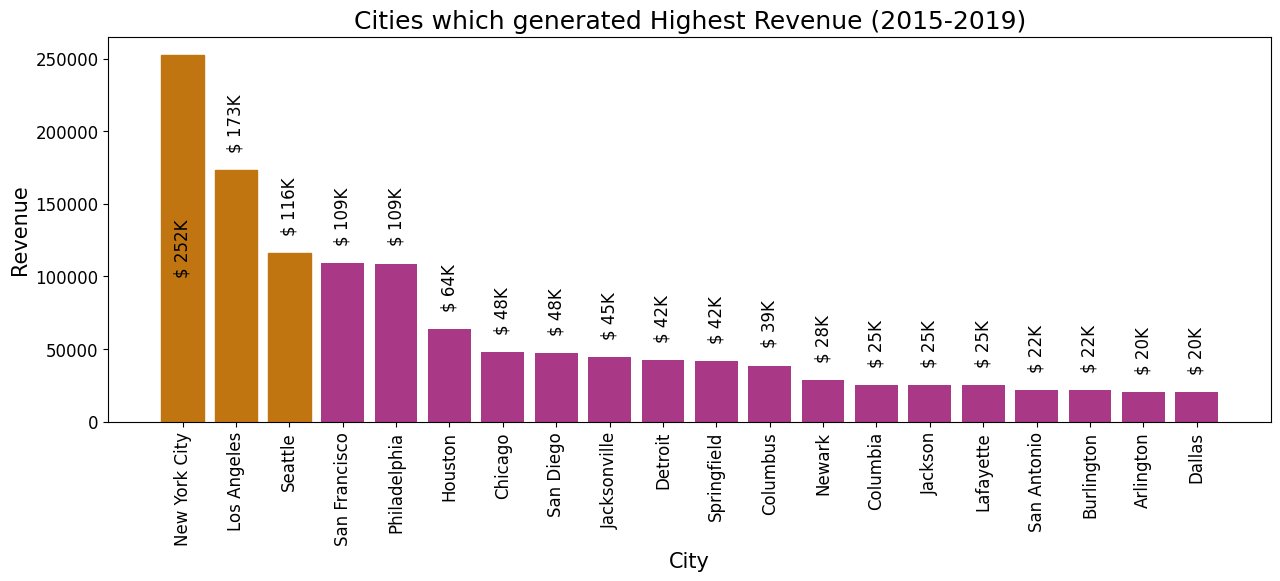

In [29]:
# Define colors for the top 3 bars
colors = ['#c17511', '#c17511', '#c17511']

plt.figure(figsize=(15, 5))
plt.title("Cities which generated Highest Revenue (2015-2019)", fontsize=18)

# Plot bars with different colors for the top 3
bars = plt.bar(Top_cities["City"], Top_cities["Sales"], color=['#a93886'] * len(Top_cities))

# Assign different colors to the top 3 bars
for i in range(3):
    bars[i].set_color(colors[i])

plt.xlabel("City", fontsize=15)
plt.ylabel("Revenue", fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

# Add annotations with revenue in K (thousands)
for k, v in Top_cities["Sales"].items():
    revenue_in_k = v / 1000  # Convert revenue to thousands
    if revenue_in_k > 250:
        plt.text(k, v - 150000, f'$ {revenue_in_k:.0f}K', fontsize=12, rotation=90, color='k', horizontalalignment='center')
    else:
        plt.text(k, v + 15000, f'$ {revenue_in_k:.0f}K', fontsize=12, rotation=90, color='k', horizontalalignment='center')

plt.show()

In [30]:
# Top Sales Revenue per Category

Top_category = df.groupby(["Category"]).sum().sort_values("Sales", ascending=False)  # Sort the Categories as per the sales
Top_category = Top_category[["Sales"]] # keep only the sales column in the dataframe
total_revenue_category = Top_category["Sales"].sum() # To find the total revenue generated as per category
total_revenue_category = str(int(total_revenue_category)) # Convert the total_revenue_category from float to int and then to string
total_revenue_category = '$' + total_revenue_category # Adding '$' sign before the Value
Top_category.reset_index(inplace=True) # Since we have used groupby, we will have to reset the index to add the category into the dataframe

<ipython-input-30-1ad773628cb8>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Top_category = df.groupby(["Category"]).sum().sort_values("Sales", ascending=False)  # Sort the Categories as per the sales


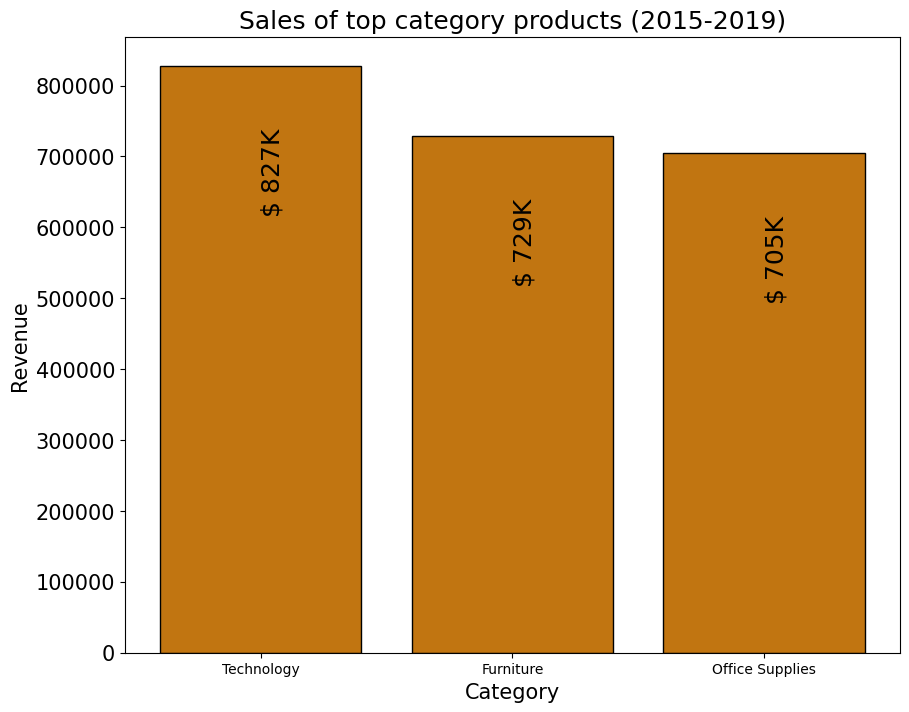

In [31]:
plt.figure(figsize = (10,8))
plt.title("Sales of top category products (2015-2019)", fontsize=18)
plt.bar(Top_category["Category"], Top_category["Sales"],color= '#c17511',edgecolor='black', linewidth = 1)
plt.xlabel("Category",fontsize=15)
plt.ylabel("Revenue",fontsize=15)
plt.yticks(fontsize=15)

for k, v in Top_category["Sales"].items():
    revenue_in_k = v / 1000  # Convert revenue to thousands
    if revenue_in_k > 250:
        plt.text(k, v - 150000, f'$ {revenue_in_k:.0f}K', fontsize=18, rotation=90, color='k', verticalalignment='center')
    else:
        plt.text(k, v + 15000, f'$ {revenue_in_k:.0f}K', fontsize=18, rotation=90, color='k', verticalalignment='center')

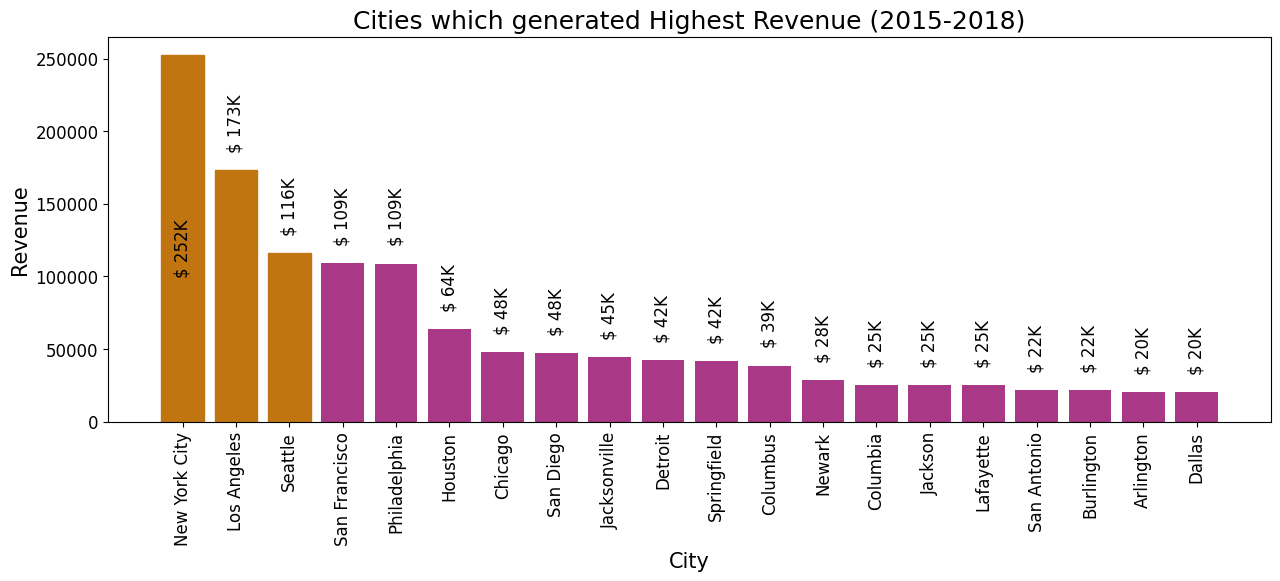

In [32]:
# Define colors for the top 3 bars
colors = ['#c17511', '#c17511', '#c17511']

plt.figure(figsize=(15, 5))
plt.title("Cities which generated Highest Revenue (2015-2018)", fontsize=18)

# Plot bars with different colors for the top 3
bars = plt.bar(Top_cities["City"], Top_cities["Sales"], color=['#a93886'] * len(Top_cities))

# Assign different colors to the top 3 bars
for i in range(3):
    bars[i].set_color(colors[i])

plt.xlabel("City", fontsize=15)
plt.ylabel("Revenue", fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

# Add annotations with revenue in K (thousands)
for k, v in Top_cities["Sales"].items():
    revenue_in_k = v / 1000  # Convert revenue to thousands
    if revenue_in_k > 250:
        plt.text(k, v - 150000, f'$ {revenue_in_k:.0f}K', fontsize=12, rotation=90, color='k', horizontalalignment='center')
    else:
        plt.text(k, v + 15000, f'$ {revenue_in_k:.0f}K', fontsize=12, rotation=90, color='k', horizontalalignment='center')

plt.show()

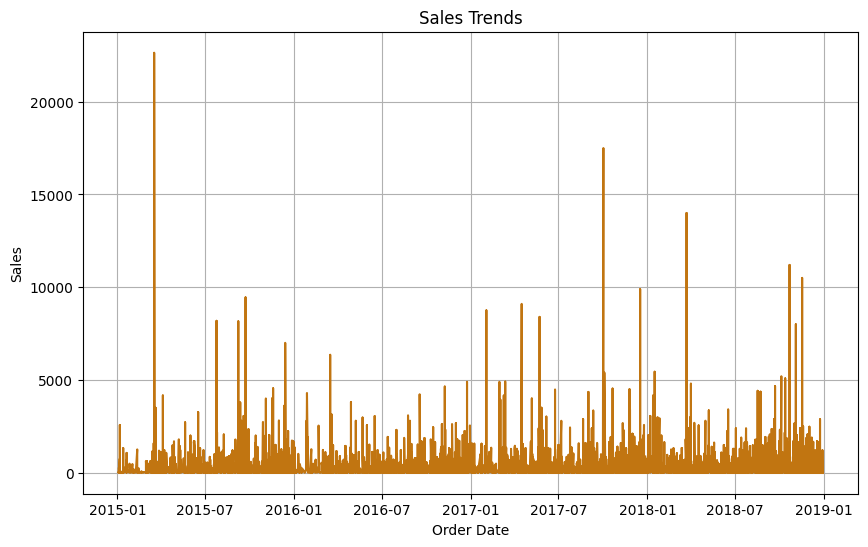

In [33]:
# Plotting Data untuk memahami sebaran penjualan

plt.figure(figsize=(10, 6))
plt.plot(df2['Order Date'], df2['Sales'], linestyle='-', color='#c17511')
plt.title('Sales Trends')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


In [34]:
# Menghitung Penjualan

monthly_stats = df2.resample('M', on='Order Date').agg({'Sales': ['mean', 'std']})
print(monthly_stats)

                 Sales             
                  mean          std
Order Date                         
2015-01-31  184.489701   373.096741
2015-02-28   98.258522   199.686514
2015-03-31  358.479201  1855.169002
2015-04-30  214.668115   457.918560
2015-05-31  195.407463   372.501350
2015-06-30  262.007142   477.515820
2015-07-31  237.898190   736.007735
2015-08-31  185.736551   311.853176
2015-09-30  305.706093   904.378570
2015-10-31  197.820082   381.797984
2015-11-30  254.600198   533.009204
2015-12-31  248.784885   590.497266
2016-01-31  316.964168   732.060315
2016-02-29  186.740797   377.933572
2016-03-31  252.650925   673.737352
2016-04-30  214.807978   413.935042
2016-05-31  209.507206   447.879133
2016-06-30  182.940884   374.248768
2016-07-31  210.354846   342.958325
2016-08-31  233.027482   437.701978
2016-09-30  221.521425   444.522184
2016-10-31  189.095960   334.622162
2016-11-30  234.421805   489.657543
2016-12-31  239.690036   500.861460
2017-01-31  208.342596   363

In [35]:
# Top Sales Revenue by Product

Top_products = df.groupby(["Product Name"]).sum().sort_values("Sales",ascending=False).head(8)
Top_products = Top_products[["Sales"]].round(2)
Top_products.reset_index(inplace=True)
total_revenue_products = Top_products["Sales"].sum()
total_revenue_products = str(int(total_revenue_products))
total_revenue_products = '$' + total_revenue_products

<ipython-input-35-f505a7d9eb9b>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Top_products = df.groupby(["Product Name"]).sum().sort_values("Sales",ascending=False).head(8)


In [36]:
autopct_format = "{:.1f}%"

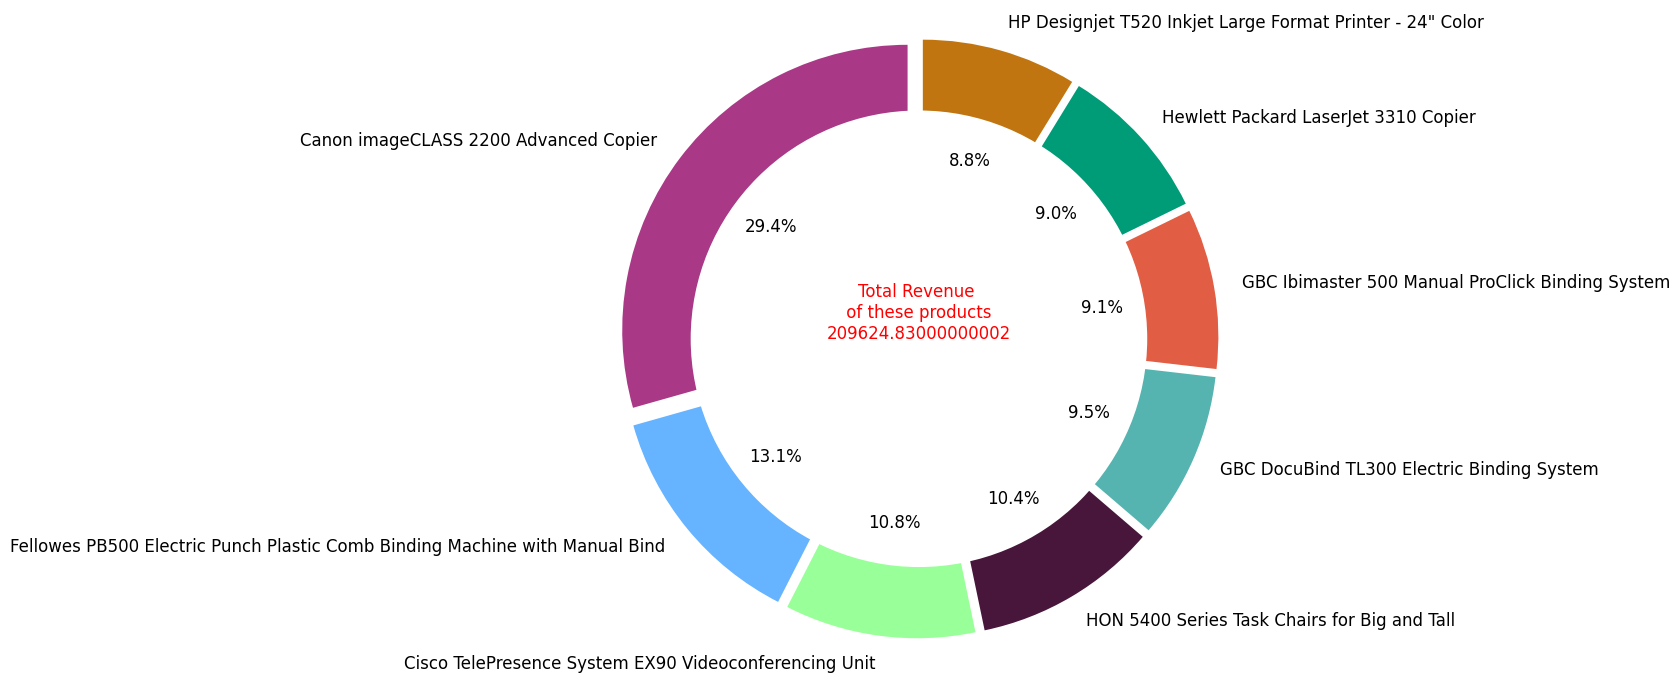

In [37]:
import matplotlib.pyplot as plt

# Define autopct_format function
def autopct_format(value):
    return f'{value:.1f}%'

plt.rcParams["figure.figsize"] = (13, 7)
plt.rcParams['font.size'] = 12.0
colors = ['#a93886', '#66b3ff', '#99ff99', '#47163a', '#55B4B0', '#E15D44', '#009B77', '#c17511']
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

# Assuming Top_products is a DataFrame with 'Sales' and 'Product Name' columns
fig1, ax1 = plt.subplots()
ax1.pie(Top_products['Sales'], colors=colors, labels=Top_products['Product Name'],
        autopct=autopct_format, startangle=90, explode=explode)

centre_circle = plt.Circle((0, 0), 0.80, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')
total_revenue_products = sum(Top_products['Sales'])
label = ax1.annotate('Total Revenue \n of these products \n' + str(total_revenue_products),
                     color='red', xy=(0, 0), fontsize=12, ha="center")

plt.tight_layout()
plt.show()


# Model SARIMA


In [38]:
from pmdarima import auto_arima

In [39]:
# train-set size
size = 0.8
# split the dataset
train, test = sale_monthly.iloc[:int(size*len(sale_monthly))], sale_monthly.iloc[int(size*len(sale_monthly)):]

In [40]:
# Membuat Model

model_param = auto_arima(train, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=605.030, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=614.235, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=596.138, Time=0.38 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=605.643, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=678.987, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=615.060, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=609.828, Time=0.48 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=598.020, Time=0.41 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=605.704, Time=0.32 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=594.546, Time=0.20 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=596.279, Time=0.56 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=605.367, Time=0.28 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=604.379, Time=0.20 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   

In [41]:
order = (0, 0, 0)  # (p, d, q)
seasonal_order = (1, 0, 0, 12)  # (P, D, Q, s)

In [42]:
# Train Model

model_sarima = SARIMAX(train, order=order, seasonal_order=seasonal_order)
train_model_sarima = model_sarima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [43]:
train_model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                    Sales   No. Observations:                   38
Model:             SARIMAX(1, 0, 0, 12)   Log Likelihood                -306.345
Date:                  Thu, 29 Feb 2024   AIC                            616.690
Time:                          07:02:47   BIC                            619.965
Sample:                      01-31-2015   HQIC                           617.855
                           - 02-28-2018                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9635      0.027     35.820      0.000       0.911       1.016
sigma2      2.548e+05   7.41e+04      3.439      0.001     1.1e+05       4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.13
Prob(Q):                              0.95   Prob(JB):                         0.21
Heteroskedasticity (H):               1.85   Skew:                            -0.52
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

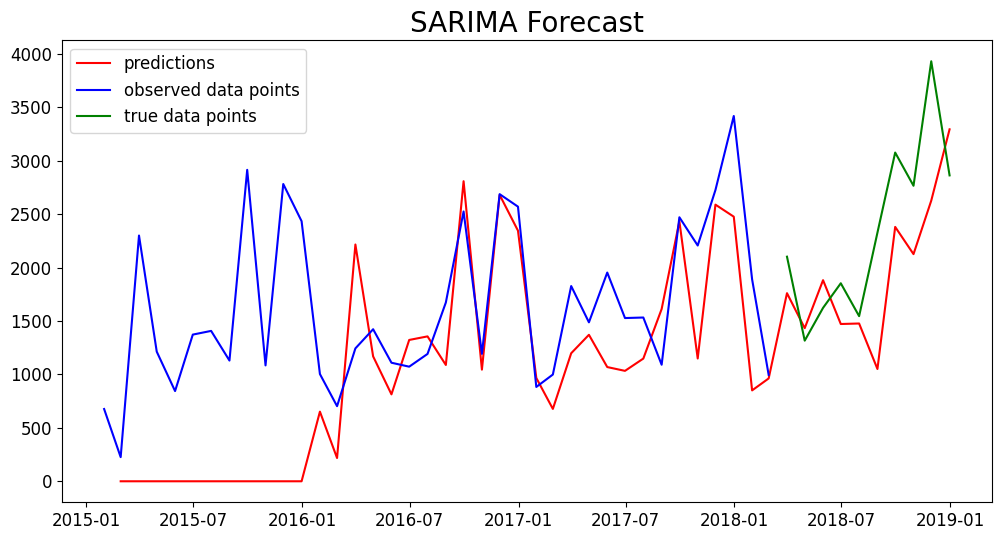

In [83]:
# Melakukan Prediksi

# make prediction on the whole set (train and test) so we can see how the model run
sarima_predictions = train_model_sarima.get_prediction(start='2015-01-31', end='2018-12-31')
# get the confidence interval
CI = sarima_predictions.conf_int()
test_CI = CI.loc[test.index[0]:]

#plot the results
plt.figure(figsize=(12,6))
plt.plot(sarima_predictions.predicted_mean[1:],color='red',label='predictions')
plt.plot(train,color='blue',label='observed data points')
plt.plot(test,color='green',label='true data points')

plt.title('SARIMA Forecast',size=20)
plt.legend(loc='best')

In [73]:
sale_monthly = sale_monthly[:24]

In [45]:
# Evaluasi Model

forecast_error = sale_monthly['Sales'][1:] - sarima_predictions.predicted_mean[1:]

# Mean forecast error
mean_forecast_error = np.mean(forecast_error)
print(mean_forecast_error)

357.6766732123315


In [46]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score

In [84]:
print(f"MAE: {mean_absolute_error(sale_monthly,sarima_predictions.predicted_mean)}")
print(f"MAPE: {mean_absolute_percentage_error(sale_monthly,sarima_predictions.predicted_mean)}")
print(f"RMSE: {np.sqrt(mean_squared_error(sale_monthly,sarima_predictions.predicted_mean))}")
print(f"MSE: {mean_squared_error(sale_monthly,sarima_predictions.predicted_mean)}")
print(f"R-Squared: {r2_score(sale_monthly,sarima_predictions.predicted_mean)}")

MAE: 721.0311043781512
MAPE: 0.44194535285045217
RMSE: 1003.5981041612715
MSE: 1007209.1546760985
R-Squared: -0.5583488455607937


# Exponential smoothing (ETS) Model

In [48]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [49]:
# train-set size
size2 = 0.8

# split the dataset
train_ets, test_ets = sale_monthly.iloc[:int(size*len(sale_monthly))], sale_monthly.iloc[int(size*len(sale_monthly)):]

In [50]:
# Train Model ETS
model_ets = ExponentialSmoothing(train_ets['Sales'], trend='add', seasonal='add', seasonal_periods=12)
result_ets_model = model_ets.fit()

In [87]:
# Melakukan prediksi
forecast_ets = result_ets_model.predict(start='2015-01-31', end='2018-12-31')

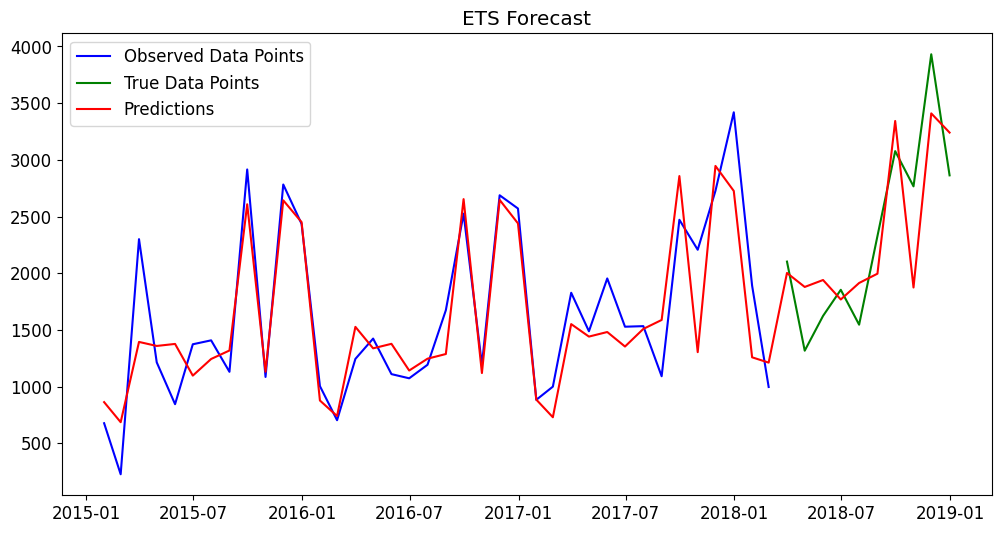

In [88]:
# Plot hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(train_ets.index, train_ets['Sales'], color='blue', label='Observed Data Points')
plt.plot(test_ets.index, test_ets['Sales'], color='green', label='True Data Points')
plt.plot(forecast_ets.index, forecast_ets, label='Predictions', color='red')
plt.legend()
plt.title('ETS Forecast')
plt.show()


In [89]:
# Evaluasi Model

forecast_error2 = sale_monthly['Sales'][1:] - sarima_predictions.predicted_mean[1:]

# Mean forecast error
mean_forecast_error = np.mean(forecast_error)
print(mean_forecast_error)

357.6766732123315


In [90]:
# Evaluasi Model ETS

print(f"MAE: {mean_absolute_error(sale_monthly,forecast_ets)}")
print(f"MAPE: {mean_absolute_percentage_error(sale_monthly,forecast_ets)}")
print(f"RMSE: {np.sqrt(mean_squared_error(sale_monthly,forecast_ets))}")
print(f"MSE: {mean_squared_error(sale_monthly,forecast_ets)}")
print(f"R-Squared: {r2_score(sale_monthly,forecast_ets)}")

MAE: 285.0785784286879
MAPE: 0.20454308533167942
RMSE: 369.51375809014723
MSE: 136540.41741790387
R-Squared: 0.7887453654807128


# KESIMPULAN



MAE (Mean Absolute Error):

ETS: 285.08
SARIMA: 721.03
Kesimpulan: Nilai MAE yang lebih rendah menunjukkan kinerja yang lebih baik, sehingga ETS lebih baik berdasarkan MAE.


MAPE (Mean Absolute Percentage Error):

ETS: 0.2045
SARIMA: 0.4419
Kesimpulan: Nilai MAPE yang lebih rendah juga menunjukkan kinerja yang lebih baik, sehingga ETS lebih baik berdasarkan MAPE.


RMSE (Root Mean Square Error):

ETS: 369.51
SARIMA: 1003.60
Kesimpulan: Nilai RMSE yang lebih rendah menunjukkan kinerja yang lebih baik, sehingga ETS lebih baik berdasarkan RMSE.


MSE (Mean Squared Error):

ETS: 136540.42
SARIMA: 1007209.15
Kesimpulan: Nilai MSE yang lebih rendah menunjukkan kinerja yang lebih baik, sehingga ETS lebih baik berdasarkan MSE.


R-Squared:

ETS: 0.7887
SARIMA: -0.5583
Kesimpulan: Nilai R-Squared yang lebih tinggi menunjukkan kinerja yang lebih baik, sehingga ETS lebih baik berdasarkan R-Squared.


Berdasarkan evaluasi ini, secara konsisten, model ETS memiliki kinerja yang lebih baik daripada model SARIMA dalam hal MAE, MAPE, RMSE, MSE, dan R-Squared. Oleh karena itu, berdasarkan metrik-metrik ini, ETS dapat dianggap sebagai pilihan yang lebih baik di antara kedua model tersebut.